<a href="https://colab.research.google.com/github/moo-337/moo/blob/master/docs/get_started_AutoCall_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
mu, sig, beta, n, K = 4, 0.25, 0.99, 10, 40 

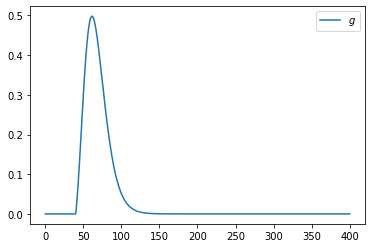

In [3]:
from scipy.stats import lognorm

def f(x):
    return lognorm.pdf(x, sig, scale=np.exp(mu))

def g(x):
    return np.maximum(x - K, 0) * f(x)

x_grid = np.linspace(0, 400, 1_000)
y_grid = g(x_grid)

fig, ax = plt.subplots()
ax.plot(x_grid, y_grid, label="$g$")
ax.legend()
plt.show()


In [4]:
from scipy.integrate import quad

integral, error = quad(g, 0, 1_000)
P = beta**n * integral
print(f"The numerical integration based option price is {P:.3f}")

The numerical integration based option price is 15.188


In [5]:
M = 10_000_000
S = np.exp(mu + sig * np.random.randn(M))
payoffs = np.maximum(S - K, 0)
P = beta ** n * payoffs.mean()
print(f"The Monte Carlo option price is {P:.3f}")

The Monte Carlo option price is 15.183


In [6]:
Model = namedtuple("Model", ("beta", "mu", "K", "cpn", "B", "n", "rho", "v", "S0", "h0"))

In [7]:
def create_model_autocall(beta=.99999, 
                 mu=-0.0001,
                 K=[0.9, 0.9, 0.85, 0.85, 0.8, 0.8],
                 cpn=[0.005, 0.01, 0.015, 0.02, 0.025, 0.03],
                 B=0.5,
                 n=1000,
                 rho=0.1,
                 v=0.01,
                 S0=1,
                 h0=0):
    return Model(beta=beta, mu=mu, K=K, cpn=cpn, B=B, n=n, rho=rho, v=v, S0=S0, h0=h0)

In [8]:
default_model = create_model_autocall()
     

In [9]:
from numpy.random import randn

def simulate_asset_price_path(model):

    beta, mu, K, cpn, B, n, rho, v, S0, h0 = model
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        h = rho * h + v * randn()
        s[t+1] = s[t] + mu + h * randn()
        
    return np.exp(s)

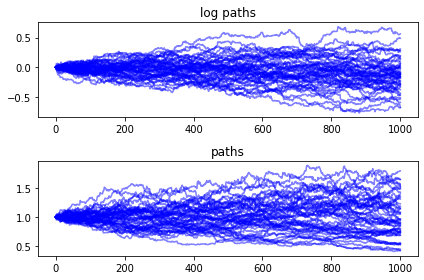

In [10]:
fig, axes = plt.subplots(2, 1)

titles = 'log paths', 'paths'
transforms = np.log, lambda x: x
for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
        path = simulate_asset_price_path(default_model)
        ax.plot(transform(path), 'b-', alpha=0.5)
    ax.set_title(title)

fig.tight_layout()
plt.show()


In [11]:
from numba import njit
# pip install --upgrade numda
default_M = 1_000_000

In [12]:
@njit
def compute_Autocall_price(model, M=default_M):

    beta, mu, K, cpn, B, n, rho, v, S0, h0 = model
    current_sum = 0.0

    early_call_n = len(K)
    early_call_idx = [(i+1)*(n//early_call_n) for i in range(early_call_n-1)]
    rnd_cnt = 0
    early_call_cnt = 0
    loss_cnt = 0
    for m in range(M):
        s = np.log(S0)
        h = h0
        early_date_cnt = 0
        barrier_flag = False
        early_call_flag = False
        for t in range(n):
            h = rho * h + v * randn()
            s = s + mu + h * randn()
            rnd_cnt += 1
            exp_s = np.exp(s)

            if t == early_call_idx[early_date_cnt]:
                if exp_s < S0*K[early_date_cnt]:
                    if early_call_n-2 != early_date_cnt:
                        early_date_cnt +=1
                    continue
                if exp_s >= S0*K[early_date_cnt]:
                    early_call_flag = True
                    early_call_cnt += 1
                    current_sum += beta**t * (1 + cpn[early_date_cnt])
                    break
            if exp_s <= S0*B:
                barrier_flag = True
        
        if not barrier_flag and not early_call_flag:
            current_sum += beta**n * (1 + cpn[-1])
        
        if barrier_flag and not early_call_flag:
            if exp_s >= S0*K[-1]:
                current_sum += beta**n * (1 + cpn[-1])
            if exp_s < S0*K[-1]:                
                current_sum += beta**n * exp_s / S0
                loss_cnt += 1

    return current_sum / M, rnd_cnt, early_call_cnt, loss_cnt

In [13]:
%%time
compute_Autocall_price(default_model)

CPU times: user 38.4 s, sys: 278 ms, total: 38.7 s
Wall time: 49.6 s


(0.989924385890308, 297620531, 900031, 29801)

In [14]:
%%time
compute_Autocall_price(default_model)

CPU times: user 32.8 s, sys: 115 ms, total: 32.9 s
Wall time: 32.9 s


(0.9900300577057808, 297815783, 900019, 29610)

In [15]:
from numba import prange

In [16]:
@njit(parallel=True)
def compute_Autocall_price_parallel(model, M=default_M):

    beta, mu, K, cpn, B, n, rho, v, S0, h0 = model
    current_sum = 0.0

    early_call_n = len(K)
    early_call_idx = [(i+1)*(n//early_call_n) for i in range(early_call_n-1)]
    rnd_cnt = 0
    early_call_cnt = 0
    loss_cnt = 0
    for m in prange(M):
        s = np.log(S0)
        h = h0
        early_date_cnt = 0
        barrier_flag = False
        early_call_flag = False
        for t in range(n):
            h = rho * h + v * randn()
            s = s + mu + h * randn()
            rnd_cnt += 1
            exp_s = np.exp(s)

            if t == early_call_idx[early_date_cnt]:
                if exp_s < S0*K[early_date_cnt]:
                    if early_call_n-2 != early_date_cnt:
                        early_date_cnt +=1
                    continue
                if exp_s >= S0*K[early_date_cnt]:
                    early_call_flag = True
                    early_call_cnt += 1
                    current_sum += beta**t * (1 + cpn[early_date_cnt])
                    break
            if exp_s <= S0*B:
                barrier_flag = True
        
        if not barrier_flag and not early_call_flag:
            current_sum += beta**n * (1 + cpn[-1])
        
        if barrier_flag and not early_call_flag:
            if exp_s >= S0*K[-1]:
                current_sum += beta**n * (1 + cpn[-1])
            if exp_s < S0*K[-1]:                
                current_sum += beta**n * exp_s / S0
                loss_cnt += 1

    return current_sum / M, rnd_cnt, early_call_cnt, loss_cnt

In [17]:
%%time
compute_Autocall_price_parallel(default_model)

/usr/local/lib/python3.9/dist-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument '_K_11' of function '__numba_parfor_gufunc_0x7effd66b6af0'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<string>", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.9/dist-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument '_cpn_12' of function '__numba_parfor_gufunc_0x7effd66b6af0'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<string>", line 1:
<source missing, REPL/exec 

CPU times: user 39.4 s, sys: 55.8 ms, total: 39.5 s
Wall time: 25 s


(0.9901306448204226, 297787932, 899896, 29420)

In [18]:
%%time
compute_Autocall_price_parallel(default_model)

CPU times: user 35.6 s, sys: 26.8 ms, total: 35.6 s
Wall time: 21.4 s


(0.9900774402558803, 297735757, 900079, 29521)

In [19]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/lib/python3.9/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-11.8/nvvm/libdevice
find: ‘/proc/60/task/60/net’: Invalid argument
find: ‘/proc/60/net’: Invalid argument
/usr/local/cuda-11.8/nvvm/lib64/libnvvm.so
find: ‘/proc/60/task/60/net’: Invalid argument
find: ‘/proc/60/net’: Invalid argument
find: ‘/proc/1039’: No such file or directory


In [20]:
from math import log, exp
from numba import cuda, objmode, float32, int32
from numba.cuda.random import xoroshiro128p_normal_float32 as xnf32
from numba.cuda.random import create_xoroshiro128p_states as x128_states

In [21]:
def convert_to_32_bit(scalar):
    if isinstance(scalar, float):
        return float32(scalar)
    return(int32(scalar))

In [22]:
@cuda.jit(device=True)
def update_price(params, s, h, zeta_1, zeta_2):
    beta, mu, K, n, rho, v = params
    h = rho * h + v * zeta_2
    s = s + mu + h * zeta_1
    return s, h

In [23]:
@cuda.jit
def price_generation_kernel(model, init_vals, price_sample, rng_states):

    pos = cuda.grid(1)
    beta, mu, K, cpn, B, n, rho, v, S0, h0 = model
    params = tuple(map(convert_to_32_bit, (beta, mu, K, n, rho, v)))
    S0, h0 = init_vals

    s, h = log(S0), h0

    early_call_n = len(K)
    early_call_idx = [(i+1)*(n//early_call_n) for i in range(early_call_n-1)]
    early_call_cnt = 0
    for t in range(n):

        zeta_1 = xnf32(rng_states, pos)
        zeta_2 = xnf32(rng_states, pos)
        s, h = update_price(params, s, h, zeta_1, zeta_2)
        if t == early_call_idx[early_call_cnt]:

            price_sample[pos] = exp(s)

In [24]:
def compute_Autocall_price_cuda(model,
                            M=default_M,
                            seed=1234,
                            threads_per_block=132):
    
    nthreads = threads_per_block
    nblocks = M // nthreads
    beta, mu, K, cpn, B, n, rho, v, S0, h0 = model
    params = tuple(map(convert_to_32_bit, (beta, mu, K, n, rho, v)))
    init_vals = tuple(map(convert_to_32_bit, (S0, h0)))

    rng_states = x128_states(M, seed=seed)

    price_sample = cuda.to_device(np.zeros(M))

    price_generation_kernel[nblocks, nthreads](
        params, init_vals, price_sample, rng_states
    )

    price_sample = price_sample.copy_to_host()
    payoffs = np.maximum(price_sample - K, 0)
    return beta**n * np.mean(payoffs)

In [25]:
# %%time
# compute_Autocall_price_cuda(default_model)

In [26]:
# %%time
# compute_Autocall_price_cuda(default_model)

In [27]:
import jax
import jax.numpy as jnp

In [28]:
def compute_Autocall_price_jax(model=default_model, 
                           M=default_M,
                           key=jax.random.PRNGKey(1)):
    
    beta, mu, K, cpn, B, n, rho, v, S0, h0 = model
    
    early_call_n = len(K)
    early_call_idx = [(i+1)*(n//early_call_n) for i in range(early_call_n-1)]
    early_call_cnt = 0
    
    s = jnp.full(M, jnp.log(S0))
    h = jnp.full(M, h0)
    uncalled_idx = jnp.full(M, 1)
    barrier_idx = jnp.full(M, 1)
    expectation = 0 
    for t in range(n):
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (2, M))
        
        h = rho * h + v * Z[1, :]
        s = s + mu + h * Z[0, :]
        observe_s = jnp.exp(s)
        barrier_idx *= jnp.maximum(jnp.sign(observe_s - B*(S0+1e-10)), 0)

        if t == early_call_idx[early_call_cnt]:
            observe_s *= uncalled_idx
            called_idx = jnp.maximum(jnp.sign(observe_s - K[early_call_cnt]*S0), 0)
            expectation += jnp.mean(called_idx) * beta**t * (1 + cpn[early_call_cnt])
            uncalled_idx -= called_idx
            if early_call_n-2 != early_call_cnt:
                early_call_cnt += 1

    expectation += jnp.mean(uncalled_idx * barrier_idx) * beta**n * (1 + cpn[-1])
    
    uncalled_idx = uncalled_idx - uncalled_idx * barrier_idx

    expectation += jnp.mean(uncalled_idx * observe_s / S0) * beta**n

    return expectation

In [29]:
%%time
compute_Autocall_price_jax().block_until_ready()

CPU times: user 54.1 s, sys: 3.49 s, total: 57.6 s
Wall time: 38.4 s


Array(0.9900861, dtype=float32)

In [30]:
%%time
compute_Autocall_price_jax().block_until_ready()

CPU times: user 53.4 s, sys: 1.56 s, total: 55 s
Wall time: 36.1 s


Array(0.9900861, dtype=float32)

In [31]:
compute_Autocall_price_jax_jit = jax.jit(compute_Autocall_price_jax)

In [ ]:
%%time
compute_Autocall_price_jax_jit().block_until_ready()

In [ ]:
%%time
compute_Autocall_price_jax_jit().block_until_ready()